# Scooter Rental Service Analysis

Scooter rental service GoFast provided data on user trips from several cities. To travel around the city, GoFast users use a mobile application. The service can be used with or without a subscription. It is necessary to analyze the data and test hypotheses that can help the business grow:

- subscribers spend more time on trips than non-subscribers;
- the average distance that subscribers travel per trip does not exceed 3130 meters;
- monthly revenue from subscribers is higher than revenue from non-subscribers.

**Research Objective:** conducting a comparison of the behavior of users of the scooter rental service with and without a subscription to assist in determining further development strategies for the service.

**Research Tasks:**

- Assess the suitability of the initial data for further analysis and conduct data preprocessing.
- Identify the most frequent values of user characteristics such as city of residence, subscription status, age, distance, and duration of trips.
- Compare the characteristics of users with and without a subscription.
- Test hypotheses about the similarity of behavior between users with and without a subscription.

## Summary of the Analysis Results

Based on the data analysis results:

- The data is equally representative for all 8 cities where the service operates.
- The highest number of service users is in Pyatigorsk, and the lowest - in Moscow.
- The number of non-subscribers exceeds the number of subscribers by 19% (835 vs. 699).
- The most common age range of users is 22-28 years.
- Two scooter usage strategies were identified: for short distances (peak value - 750 meters) and for long distances (peak value - 3000 meters) (this data can be used to adjust pricing plans).
- The most frequent trip duration is 12-22 minutes.
- A peak of 0.5-minute trips with a significant distance covered was identified, characteristic only for non-subscribers. This may indicate a technical malfunction in the application.

Based on the hypothesis testing results:

- With the highest probability, subscribers will spend more time on trips than non-subscribers and will also generate more revenue.
- There is a 33% probability that the average distance traveled by a subscriber will be 3130 meters.

## Data Overview

Importing the necessary libraries for data analysis:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from scipy import stats as st
from math import factorial
from scipy.special import comb
import pylab as pl
import json

Reading the files `users_go.csv`, `subscriptions_go.csv`, and `rides_go.csv` containing the data (the path to the data is stored in JSON files) and saving them in the corresponding variables `users`, `subscriptions`, `rides`:

In [2]:
# Reading of JSON file
with open('config.json', 'r', encoding='utf-8') as f:
    config = json.load(f)

# Reading the CSV file using the path from the JSON file
dataset_path_users = config['dataset_path_users_go']
dataset_path_subscriptions = config['dataset_path_subscriptions_go']
dataset_path_rides = config['dataset_path_rides_go']
users = pd.read_csv(dataset_path_users)
subscriptions = pd.read_csv(dataset_path_subscriptions)
rides = pd.read_csv(dataset_path_rides)

Removing the restrictions on displaying the number of columns, rows, and column width.

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

Displaying the first rows of each dataset and the overall information about each DataFrame.

In [4]:
# Function to display the first 10 rows and information about the DataFrame
def display_data(df, df_name):
    print(f"First 10 rows of the DataFrame {df_name}:\n")
    print(df.head(10))
    print("\nInformation about the DataFrame:\n")
    print(df.info())
    print("\n" + "="*80 + "\n")

# Main function to display data for 'users', 'subscriptions', and 'rides'
def main():
    display_data(users, 'users')
    display_data(subscriptions, 'subscriptions')
    display_data(rides, 'rides')

# Run the main function
main()

First 10 rows of the DataFrame users:

   user_id        name  age            city subscription_type
0        1        Кира   22          Тюмень             ultra
1        2   Станислав   31            Омск             ultra
2        3     Алексей   20          Москва             ultra
3        4  Константин   26  Ростов-на-Дону             ultra
4        5       Адель   28            Омск             ultra
5        6      Регина   25       Краснодар             ultra
6        7       Игорь   23            Омск             ultra
7        8        Юрий   23       Краснодар             ultra
8        9          Ян   21       Пятигорск             ultra
9       10     Валерий   18    Екатеринбург             ultra

Information about the DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int6

From the initial rows of each DataFrame, it can be concluded that they contain relevant data. All DataFrames have no missing values.

## Data Preprocessing

The data type of the date column in the `rides` DataFrame is `object`. Let's rewrite the values in `datetime` format:

In [5]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

Creating a new column with the month number based on the `date` column:

In [6]:
rides['month'] = rides['date'].dt.month

Additionally, checking for missing values in the `users` and `rides` DataFrames using the `isna()` method:

In [7]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [8]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

There are no missing values in all DataFrames. Let's check for obvious duplicates in the DataFrames:

In [9]:
users.duplicated().sum()

31

In [10]:
rides.duplicated().sum()

0

Removing obvious duplicates from the `users` DataFrame and reset the DataFrame indices:

In [11]:
users = users.drop_duplicates().reset_index()

Checking for the absence of typos in the city names:

In [12]:
users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

Translating the `city` column values in English:

In [13]:
# Creating a dictionary with Russian to English translations for the city names
translations = {
    'Тюмень': 'Tyumen',
    'Омск': 'Omsk',
    'Москва': 'Moscow',
    'Ростов-на-Дону': 'Rostov-on-Don',
    'Краснодар': 'Krasnodar',
    'Пятигорск': 'Pyatigorsk',
    'Екатеринбург': 'Yekaterinburg',
    'Сочи': 'Sochi'
}

# Applying the translation to the 'city' column
users['city'] = users['city'].map(translations)

It can be concluded that all DataFrames contain complete data, obvious duplicates have been removed, and there are no hidden duplicates.

## Data Analysis

### Distribution of Users by City

Let's determine which city has the highest number of users and visualize the obtained information:

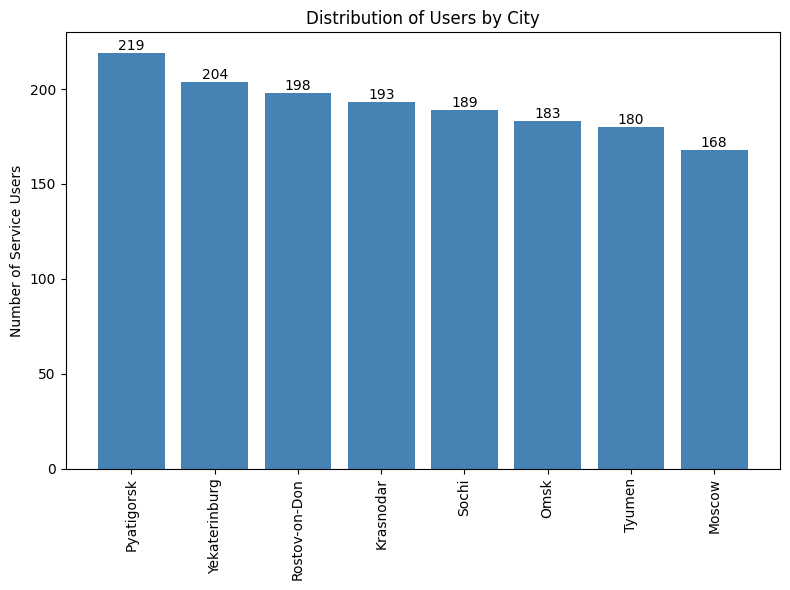

In [14]:
# Creating a bar chart
plt.figure(figsize=(8, 6))
ax = plt.gca()  # Get the current axes
bars = ax.bar(users['city'].value_counts().index, 
              users['city'].value_counts().values, 
              color='steelblue')

ax.set_ylabel('Number of Service Users')
ax.set_title('Distribution of Users by City')
ax.set_xticks(range(len(users['city'].value_counts().index)))
ax.set_xticklabels(users['city'].value_counts().index, rotation=90)

# Adding labels to the bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, 
            height, 
            f'{height:.0f}', 
            ha='center', 
            va='bottom')

# Showing the plot
plt.tight_layout()
plt.show()

The distribution of cities by the number of service users in the DataFrame is quite uniform, without any peak values. The DataFrame contains data from 8 cities where the service was launched. The highest number of users is in Pyatigorsk, and the lowest is in Moscow.

### Ratio of Subscribed and Non-Subscribed Users

Let's determine the ratio of subscribed and non-subscribed users and visualize the obtained data:

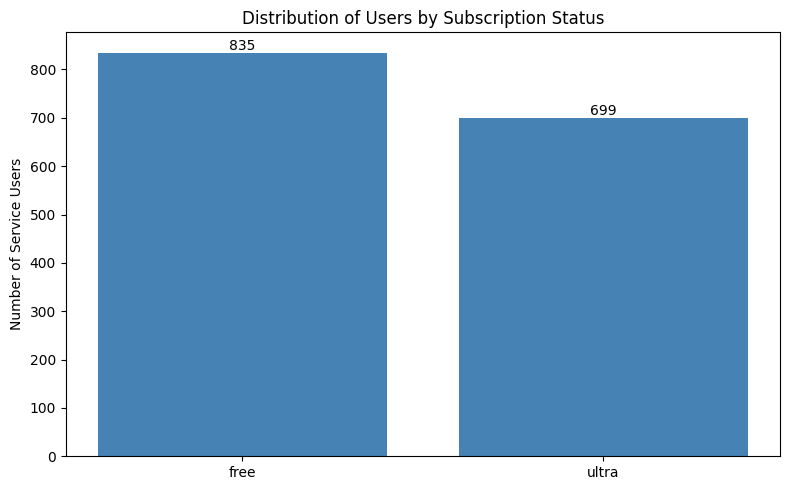

In [15]:
# Creating a bar chart
plt.figure(figsize=(8, 5))
ax = plt.gca()  # Getting the current axes
bars = ax.bar(sorted(users['subscription_type'].unique()), 
              users['subscription_type'].value_counts(), 
              color='steelblue')

ax.set_ylabel('Number of Service Users')
ax.set_title('Distribution of Users by Subscription Status')
ax.set_xticks(range(len(users['subscription_type'].value_counts().index)))
ax.set_xticklabels(users['subscription_type'].value_counts().index, rotation=0)

# Adding labels to the bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, 
            height, 
            f'{height:.0f}', 
            ha='center', 
            va='bottom')

# Showing the plot
plt.tight_layout()
plt.show()

Displaying the ratio of subscribed and non-subscribed users:

In [16]:
subsc_ratio = users.loc[users['subscription_type'] == 'free']['subscription_type'].count()/\
              users.loc[users['subscription_type'] == 'ultra']['subscription_type'].count()
subsc_ratio.round(2)

1.19

The number of users without a subscription exceeds the number of users with a subscription by 19% (835 users without a subscription compared to 699 with a subscription).

### Users' Age

Let's determine the number of users for each age group and visualize the obtained data:

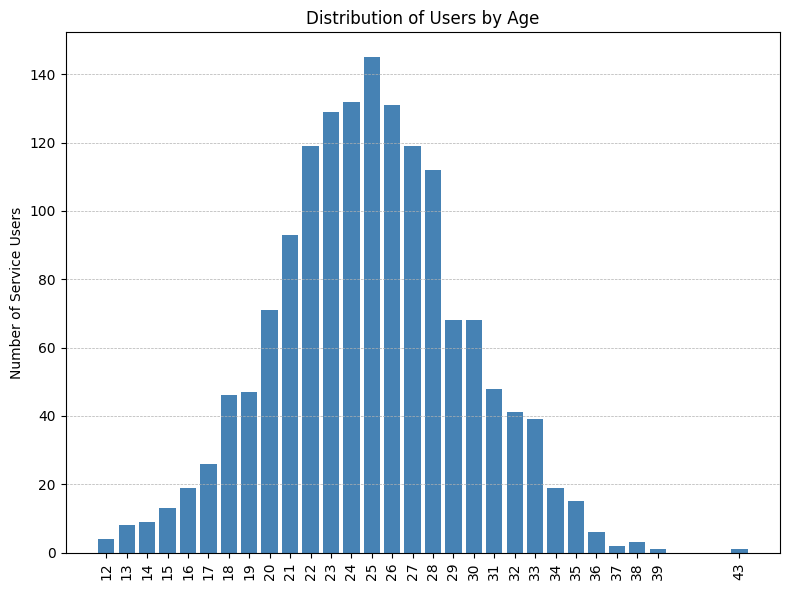

In [17]:
# Creating a bar chart
plt.figure(figsize=(8, 6))
ax = plt.gca()  # Get the current axes

# Grouping data by age and count the number of users for each age
age_counts = users.groupby('age')['user_id'].count().sort_index()

# Plotting the bar chart
bars = ax.bar(age_counts.index, 
              age_counts.values, 
              color='steelblue')

ax.set_ylabel('Number of Service Users')
ax.set_title('Distribution of Users by Age')
ax.set_xticks(age_counts.index)
ax.set_xticklabels(age_counts.index, rotation=90)
ax.grid(axis='y', which='both', linestyle='--', linewidth=0.5)

# Showing the plot
plt.tight_layout()
plt.show()

As seen from the chart, the majority of scooter rental users fall within the age range of 22 to 28 years. The minimum age of users is 12, and the maximum is 43.

### Distance Covered by Users per Trip

Let's display the overall statistics of the distance covered by users per trip and visualize the entire array of this data by creating a histogram.

In [18]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

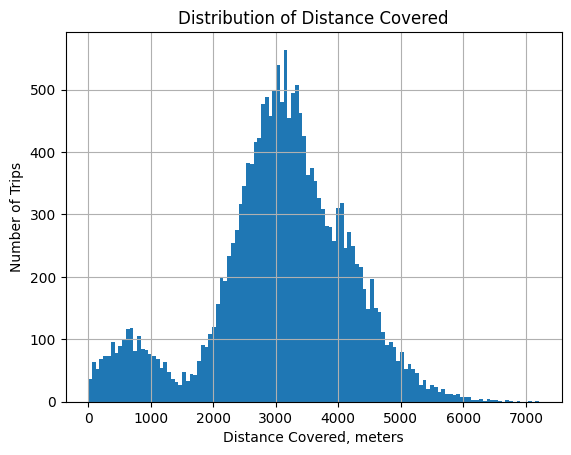

In [19]:
rides['distance'].hist(bins=120).set(title='Distribution of Distance Covered',
                                     xlabel='Distance Covered, meters',
                                     ylabel='Number of Trips');

Trips can be divided into two unequal groups:

- Short distances (e.g., to reach the metro or other public transport), with a peak distance around 750 meters.
- Long distances (for trips within the city), with a peak value of 3000 meters.

### Trip Duration

Let's display and visualize the overall data about trip durations.

In [20]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

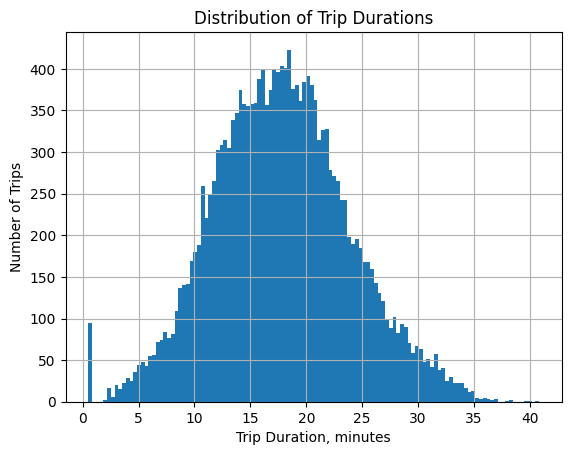

In [21]:
rides['duration'].hist(bins=120).set(title='Distribution of Trip Durations',
                                     xlabel='Trip Duration, minutes',
                                     ylabel='Number of Trips');

For most users, the trip duration ranges from 12 to 22 minutes. However, there is a significant spike in values around 0 minutes on the diagram. Let's determine the size and count of such values:

In [22]:
# Displaying trips with durations less than 2 minutes
rides.loc[rides['duration'] < 2]

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
6860,724,6225.520342,0.5,2021-12-16,12
6883,726,4452.491518,0.5,2021-03-01,3
7018,735,4406.954812,0.5,2021-04-13,4
7160,745,5286.167732,0.5,2021-08-17,8
7364,760,4881.391865,0.5,2021-08-29,8


In [23]:
# Displaying the number of very short trips
len(rides.loc[rides['duration'] < 2])

95

In 95 cases, users took scooters for half a minute, covering distances ranging from 4 to 7 km. It can be assumed that there was a data entry error in recording trip durations.

Let's replace trip durations of 0.5 minutes with the median value based on the distance covered tsarting with adding a column to the rides DataFrame indicating categories based on the distance covered:

In [24]:
def distance(length):
    try:
        if 0 <= length <= 1000:
            return 'Under 1 km'
        elif 1000 <= length <= 2000:
            return 'Under 2 km'
        elif 2000 <= length <= 3000:
            return 'Under 3 km'
        elif 3000 <= length <= 4000:
            return 'Under 4 km'
        elif 4000 <= length <= 5000:
            return 'Under 5 km'
        elif 5000 <= length <= 6000:
            return 'Under 6 km'
        elif 6000 <= length <= 7000:
            return 'Under 7 km'
        elif length >= 7000:
            return 'Under 8 km'
    except:
        pass

rides['distance_category'] = rides['distance'].apply(distance)

In [25]:
# Display the first 5 rows to check the code has applied
rides.head(5)

,user_id,distance,duration,date,month,distance_category
0,1,4409.919140,25.599769,2021-01-01,1,Under 5 km
1,1,2617.592153,15.816871,2021-01-18,1,Under 3 km
2,1,754.159807,6.232113,2021-04-20,4,Under 1 km
3,1,2694.783254,18.511000,2021-08-11,8,Under 3 km
4,1,4028.687306,26.265803,2021-08-28,8,Under 5 km


Replacing the value of 0.5 minutes in the `duration` column with the median value based on the category of the distance covered:

In [26]:
for t in rides['distance_category'].unique():
    rides.loc[(rides['distance_category'] == t) & (rides['duration'] == 0.5), 'duration'] = \
    rides.loc[(rides['distance_category'] == t), 'duration'].median()

Displaying the histogram for the second time:

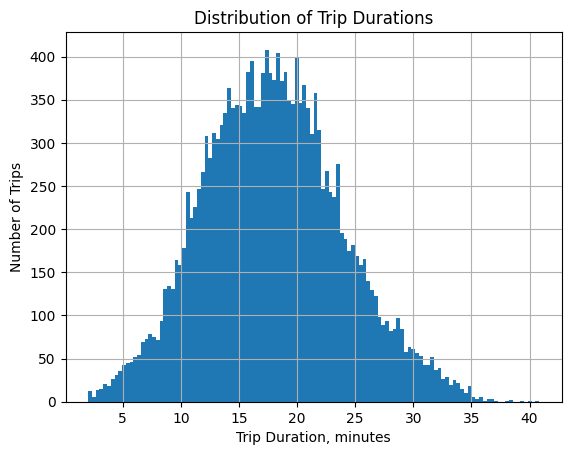

In [27]:
rides['duration'].hist(bins=120).set(title='Distribution of Trip Durations',
                                     xlabel='Trip Duration, minutes',
                                     ylabel='Number of Trips');

The primary data hasn't changed significantly; the most frequent trip duration remains between 12 to 22 minutes. The minimum trip duration is around 2 minutes, and the maximum is around 42 minutes. The peak of erroneous values around 0 has been eliminated.

## Data Merging

Merging `users`, `rides`, and `subscriptions` data into a single DataFrame using the merge() method.

In [28]:
data = rides.merge(users, 
                   on='user_id', 
                   how='left').merge(subscriptions, 
                                     on='subscription_type', 
                                     how='left')
data.head(5)

,user_id,distance,duration,date,month,distance_category,index,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Under 5 km,0,Кира,22,Tyumen,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Under 3 km,0,Кира,22,Tyumen,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Under 1 km,0,Кира,22,Tyumen,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Under 3 km,0,Кира,22,Tyumen,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Under 5 km,0,Кира,22,Tyumen,ultra,6,0,199


The original `rides` DataFrame had 18,086 rows. Let's verify that the number of rows in the merged DataFrame matches this value:

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int32         
 5   distance_category  18068 non-null  object        
 6   index              18068 non-null  int64         
 7   name               18068 non-null  object        
 8   age                18068 non-null  int64         
 9   city               18068 non-null  object        
 10  subscription_type  18068 non-null  object        
 11  minute_price       18068 non-null  int64         
 12  start_ride_price   18068 non-null  int64         
 13  subscription_fee   18068 non-null  int64         
dtypes: dat

The merged DataFrame `data` contains all necessary columns and rows for the analysis at this stage, and there are no missing values.

## Comparison of Subscribed and Non-Subscribed Users

Let's visualize the data on the **distance covered by subscribed and non-subscribed users** by creating a histogram:

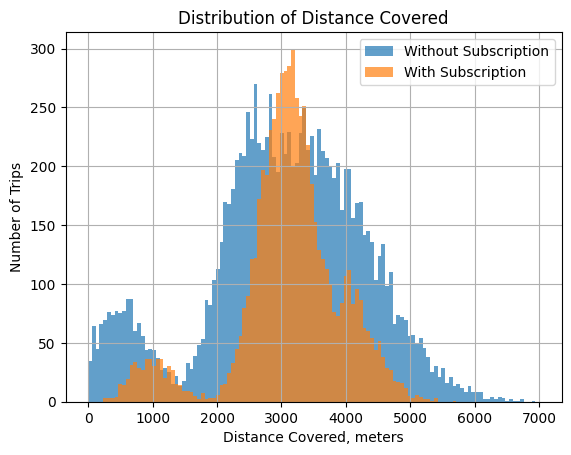

In [30]:
# Histogram for users without subscription
ax = data.loc[data['subscription_type'] == 'free']['distance'].plot(
    kind='hist',
    range=(0, 7000),
    bins=120,
    linewidth=5,
    alpha=0.7,
    label='Without Subscription',
    legend=True,
)

# Histogram for users with subscription
data.loc[data['subscription_type'] == 'ultra']['distance'].plot(
    kind='hist',
    range=(0, 7000),
    bins=120,
    linewidth=5,
    alpha=0.7,
    label='With Subscription',
    ax=ax,
    grid=True,
    legend=True, 
)

# Adding title and axis labels
ax.set(title='Distribution of Distance Covered', 
       xlabel='Distance Covered, meters', 
       ylabel='Number of Trips');

Although the number of subscribed and non-subscribed users is comparable (699 and 835 respectively), users without a subscription use the service significantly more frequently.

Non-subscribed users most often cover distances from 2.2 to 4 km (reflected as a plateau on the diagram).

Subscribed users more frequently cover 3 km (reflected as a sharp peak on the diagram).

Let's visualize the data on **trip durations for subscribed and non-subscribed users** by creating a histogram:

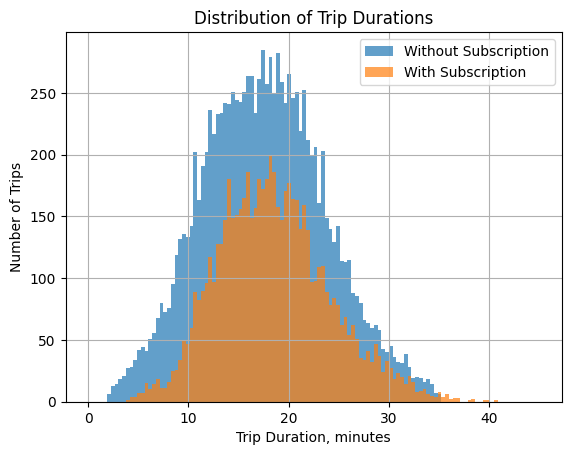

In [31]:
# Histogram for users without subscription
ax = data.loc[data['subscription_type'] == 'free']['duration'].plot(
    kind='hist',
    range=(0, 45),
    bins=120,
    linewidth=5,
    alpha=0.7,
    label='Without Subscription',
    legend=True,
)

# Histogram for users with subscription
data.loc[data['subscription_type'] == 'ultra']['duration'].plot(
    kind='hist',
    range=(0, 45),
    bins=120,
    linewidth=5,
    alpha=0.7,
    label='With Subscription',
    ax=ax,
    grid=True,
    legend=True,
)

# Adding title and axis labels
ax.set(title='Distribution of Trip Durations', 
       xlabel='Trip Duration, minutes', 
       ylabel='Number of Trips');

The histograms for subscribed and non-subscribed users are nearly identical in shape, indicating a similar distribution of values. The difference is primarily due to the disparity in the amount of data: there are significantly more trips recorded for non-subscribed users. For both groups, the most common rental duration for a scooter is between 12 and 22 minutes.

## Calculation of Monthly Revenue

**Let's create a dataframe with aggregated trip data:**
we will find the total distance, number of trips, and total duration for each user for each month.

In [32]:
# Rounding up the duration of each trip using the np.ceil() method:
data['duration'] = np.ceil(data['duration']) 

In [33]:
data_pivot = data.pivot_table(index=['user_id', 'month'],
                              values=['distance', 'duration'],
                              aggfunc={'distance': 'sum', 'duration': 'sum', 'month': 'count'})

data_pivot = data_pivot.rename(columns={'month': 'rides'})
data_pivot = data_pivot.reset_index()
data_pivot.head(10)

,user_id,month,distance,duration,rides
0,1,1,7027.511294,42.0,2
1,1,4,754.159807,7.0,1
2,1,8,6723.470560,46.0,2
3,1,10,5809.911100,32.0,2
4,1,11,7003.499363,56.0,3
5,1,12,6751.629942,28.0,2
6,2,3,10187.723006,63.0,3
7,2,4,6164.381824,40.0,2
8,2,6,3255.338202,14.0,1
9,2,7,6780.722964,48.0,2


**Adding a column to the resulting dataframe showing the monthly revenue generated by each user.**

Creating an intermediate dataframe `df1` that contains information about the subscription type and cost for each user:

In [34]:
df1 = data.loc[:, ['user_id', 'subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee']]
df1 = df1.drop_duplicates().reset_index(drop=True)
df1.head(5)

,user_id,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,ultra,6,0,199
1,2,ultra,6,0,199
2,3,ultra,6,0,199
3,4,ultra,6,0,199
4,5,ultra,6,0,199


Joining the data from the intermediate dataframe `df1` to the `pivot_table`.

In [35]:
data_pivot = data_pivot.merge(df1, on=['user_id'], how='right')
data_pivot.head(10)

,user_id,month,distance,duration,rides,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,7027.511294,42.0,2,ultra,6,0,199
1,1,4,754.159807,7.0,1,ultra,6,0,199
2,1,8,6723.470560,46.0,2,ultra,6,0,199
3,1,10,5809.911100,32.0,2,ultra,6,0,199
4,1,11,7003.499363,56.0,3,ultra,6,0,199
5,1,12,6751.629942,28.0,2,ultra,6,0,199
6,2,3,10187.723006,63.0,3,ultra,6,0,199
7,2,4,6164.381824,40.0,2,ultra,6,0,199
8,2,6,3255.338202,14.0,1,ultra,6,0,199
9,2,7,6780.722964,48.0,2,ultra,6,0,199


Calculating the monthly revenue for each user in the `data_pivot` dataframe:

In [36]:
data_pivot['monthly_revenue'] = data_pivot['minute_price'] * data_pivot['duration'] +\
                                data_pivot['subscription_fee'] + \
                                data_pivot['start_ride_price'] * data_pivot['rides']
data_pivot.head(5)

,user_id,month,distance,duration,rides,subscription_type,minute_price,start_ride_price,subscription_fee,monthly_revenue
0,1,1,7027.511294,42.0,2,ultra,6,0,199,451.0
1,1,4,754.159807,7.0,1,ultra,6,0,199,241.0
2,1,8,6723.470560,46.0,2,ultra,6,0,199,475.0
3,1,10,5809.911100,32.0,2,ultra,6,0,199,391.0
4,1,11,7003.499363,56.0,3,ultra,6,0,199,535.0


## Testing Hypotheses

### Hypothesis 1: Subscription Users Has Longer Trip Duration than Non-subscription Users.

Determining the mean duration of trips for subscription users:

In [37]:
(data.loc[data['subscription_type'] == 'ultra']['duration'].mean()).round(2)

19.04

Determining the mean duration of trips for non-subscription users:

In [38]:
(data.loc[data['subscription_type'] == 'free']['duration'].mean()).round(2)

18.07

On average, subscription users spend about 1 minute more per trip compared to non-subscription users.

To further test the hypothesis of equality of means between two populations using samples from them, we'll use the scipy.stats.ttest_ind(array1, array2, equal_var, alternative) method.

**Null Hypothesis:** Subscription users spend the same amount of time on trips on average as non-subscription users.

**Alternative Hypothesis:** Subscription users spend more time on trips on average than non-subscription users.

In [39]:
alpha = 0.05  # level of significance
# if the p-value is less than alpha, we reject the null hypothesis

results = st.ttest_ind(data.loc[data['subscription_type'] == 'ultra']['duration'], 
                       data.loc[data['subscription_type'] == 'free']['duration'], 
                       equal_var=False, 
                       alternative='greater')

print()
print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')
print()


p-value: 3.572796306092548e-27
Reject the null hypothesis



Since the null hypothesis has been rejected, we can conclude that with greater likelihood, **users with a subscription spend more time on rides than users without a subscription**.

### Hypothesis 2: The Average Distance Traveled by Users with a Subscription per Ride Does Not Exceed 3130 Meters (Optimal Distance Considering Scooter Wear).

Let's look at the average distance traveled per ride for subscribers:

In [40]:
(data.loc[data['subscription_type'] == 'ultra']['distance'].mean()).round(2)

3115.45

Subscribers on average travel just over 3115 meters, which is slightly below the threshold of 3130 meters.

Additionaly, we will test a one-sided hypothesis regarding the equality of the population mean to some value using the scipy.stats.ttest_1samp() method.

**Null Hypothesis:** The average distance traveled by subscribers in one ride is 3130 meters.

**Alternative Hypothesis:** The average distance traveled by subscribers in one ride is less than 3130 meters.

In [41]:
interested_value = 3120 # optimal distance per ride in terms of scooter wear

alpha = 0.05 # level of statistical significance

results = st.ttest_1samp(data.loc[data['subscription_type'] == 'ultra']['distance'], 
                         interested_value,
                         alternative='less') 

print()
print('p-value:', results.pvalue) 

if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')
print('Не получилось отвергнуть нулевую гипотезу')
print()


p-value: 0.3304213962773028
Fail to reject the null hypothesis
Не получилось отвергнуть нулевую гипотезу



The mean and threshold values are very close to each other, so **there is a 33% chance that the mean distance traveled by a subscription user will be equal to 3130**.

### Hypothesis 3: Monthly Revenue from Subscription Users is Higher than Revenue from Non-Subscription Users.

Calculating the average monthly revenue from subscription users:

In [42]:
(data_pivot.loc[data_pivot['subscription_type'] == 'ultra']['monthly_revenue'].mean()).round(2)

362.79

Calculating the average monthly revenue from non-subscription users:

In [43]:
(data_pivot.loc[data_pivot['subscription_type'] == 'free']['monthly_revenue'].mean()).round(2)

331.1

Subscription users contribute on average 33% more revenue than non-subscription users.

To test the hypothesis about the equality of means of two population samples we will use the scipy.stats.ttest_ind(array1, array2, equal_var, alternative) method:

**Null Hypothesis:** Monthly revenue from subscription users is equal to the revenue from non-subscription users.

**Alternative Hypothesis:** Monthly revenue from subscription users is higher than the revenue from non-subscription users.

In [44]:
alpha = 0.05  # significance level
# if the p-value is less than alpha, we reject the null hypothesis

results = st.ttest_ind(data_pivot.loc[data['subscription_type'] == 'ultra']['monthly_revenue'], 
                       data_pivot.loc[data['subscription_type'] == 'free']['monthly_revenue'],
                       equal_var=False, 
                       alternative='greater')

print()
print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')
print()


p-value: 8.600900964398781e-14
Reject the null hypothesis



It is likely that the **revenue generated by subscribers is not equal to the revenue generated by non-subscribers**. Therefore, the alternative hypothesis cannot be rejected.

Overall, it can be said that the results of hypothesis testing using methods like scipy.stats.ttest_ind and scipy.stats.ttest_1samp correspond to the actual mean values of the dataframes, except in cases where the mean and threshold values are extremely close.

Based on the results of the hypothesis testing, the following alternative hypotheses were not rejected:

- Subscribers spend more time on trips than non-subscribers.
- Monthly revenue from subscribers per month is higher than revenue from non-subscribers.

However, the null hypothesis for the following alternative was not rejected:

- The mean distance traveled by subscribers per trip does not exceed 3130 meters.

## Distributions

### Determining the Minimum Number of Mailings

The marketing department of GoFast has been tasked with conducting a promotion offering promo codes for one free month of subscription. At least 100 existing customers should renew their subscription after this promotion. After a similar promotion in the past, it was found that 10% of users renewed their subscriptions after the free trial period. The goal is to determine the minimum number of promo codes that need to be distributed so that the probability of not meeting the target is approximately 5%.

The situation described above represents a binomial distribution.

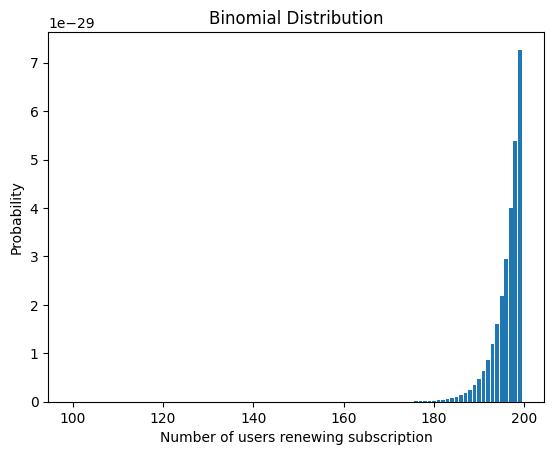


Minimum number of promo codes: 1061



In [45]:
# Setting the distribution parameters
p = 0.1  # Probability of success (user renews subscription)
k = 100  # Minimum number of successes
alpha = 0.05  # Significance level

# Finding the minimum number of promo codes using the inverse binomial distribution
n = st.nbinom.ppf(1 - alpha, k, p)

# Generating data for the plot
x = range(k, k + 100)
y = [st.nbinom.pmf(i, k, p) for i in x]

# Plotting the distribution
plt.bar(x, y)
plt.xlabel('Number of users renewing subscription')
plt.ylabel('Probability')
plt.title('Binomial Distribution')
plt.show()

print()
print(f"Minimum number of promo codes: {int(n)}")
print()

It can be concluded that 1061 is the minimum number of promo codes that need to be sent out to ensure with approximately 95% probability that 100 existing customers will renew their subscription.

### Determining the Probability of Notifications Opening

The marketing department sends push notifications to customers in the mobile app. Customers may choose to open or ignore it. It is known that around 40% of the recipients open the notifications. The department plans to send out 1 million notifications. Using approximation, it is necessary to build an approximate distribution graph and estimate the probability that no more than 399.5 thousand users will open the notification.

To approximate the binomial distribution, we will use the normal distribution with parameters calculated based on the binomial distribution. The parameters of the normal distribution are determined as follows:

Expected Value = n*p

Standard Deviation = n⋅p⋅(1−p)

where:

n - the number of notifications (1 million),
p - the probability of opening a notification (40% or 0.4).

We will use the normal approximation and the cumulative distribution function (CDF) to estimate the probability:

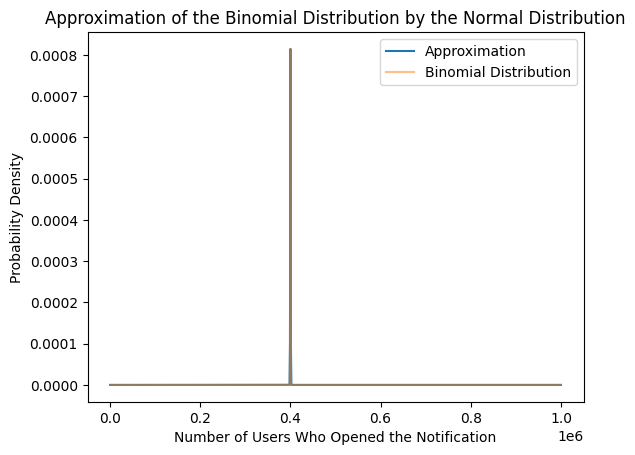


Probability that no more than 399.5 thousand users will open the notification:       0.1537


In [46]:
# Distribution parameters
n = 1000000 # Number of notifications to be sent
p = 0.4 # Probability of opening the notifications

# Normal distribution parameters
mu = n * p
sigma = np.sqrt(n * p * (1 - p))

# Generating data for the graph
x = np.arange(0, n + 1, 1000)
y = st.norm.pdf(x, mu, sigma)

# Plotting the approximation of the binomial distribution
plt.plot(x, y, label='Approximation')

# Plotting the binomial distribution (for comparison)
binomial_x = np.arange(0, n + 1)
binomial_y = st.binom.pmf(binomial_x, n, p)
plt.plot(binomial_x, binomial_y, label='Binomial Distribution', alpha=0.5)

plt.xlabel('Number of Users Who Opened the Notification')
plt.ylabel('Probability Density')
plt.title('Approximation of the Binomial Distribution by the Normal Distribution')
plt.legend()
plt.show()
print()

# Estimating the probability of no more than 399.5 thousand users opening the notification
probability_less_than_399_5k = st.norm.cdf(399500, mu, sigma)
print(f"Probability that no more than 399.5 thousand users will open the notification: \
      {probability_less_than_399_5k:.4f}")

The conclusion can be drawn that, given the condition of sending out 1 million notifications, the probability that no more than 399.5 thousand users will open these notifications is 15.37%.

## Research Results

Overall, it can be said that the data presented for analysis is complete and relevant, with no implicit duplicates, and a small number of explicit duplicates were removed.

The data is equally representative for all 8 cities where the service operates. The largest number of users is in Pyatigorsk, and the smallest is in Moscow.

The number of users without a subscription exceeds the number of users with a subscription by 19% (835 versus 699).

The most common age of users ranges from 22 to 28 years.

The distance distribution diagram revealed the presence of two unequal groups reflecting user strategies: using scooters for short distances (peak value - 750 meters) and using them for long distances (peak value - 3000 meters). These data can be used to adjust tariff plans in the future.

The most frequent trip duration is between 12 and 22 minutes.

There was a spike in trip durations of 0.5 minutes for significant distances, which is characteristic only of users without a subscription. This is likely a technical malfunction in the app, so the data was replaced with median values.

While the number of users with and without subscriptions is comparable, users without a subscription make nearly twice as many trips as users with a subscription.

It is highly likely that users with a subscription will spend more time on trips than users without a subscription and will also generate more revenue. There is a 33% chance that the average distance traveled by a user with a subscription will be 3130 meters.

To attract an additional 100 subscribers with a 95% probability, at least 1061 promo codes for a free month of subscription need to be sent out as part of the promotion.

Additionally, when sending 1 million push notifications through the mobile app, the probability that no more than 399.5 thousand users will open the notification is 15.37%.